In [37]:
import pandas as pd
import numpy as np
import string
import re
import regex
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
le = preprocessing.LabelEncoder()


In [38]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense,Dropout, Input

from tensorflow.keras import regularizers
from transformers import *
from transformers import BertTokenizer, TFBertModel, BertConfig,TFDistilBertModel,DistilBertTokenizer,DistilBertConfig


In [39]:
train_df=pd.read_excel('bert_sample.xlsx')
train_df

,ITEM_NAME,CATEGORY_ID
0,CALIBRACION TRANSDUCER 75 nm,CAPITAL ASSEMBLY
1,for pusher whskey,CAPITAL ASSEMBLY
2,Stat 40B Press Head Cup to Carrier from Stati...,CAPITAL ASSEMBLY
3,TRANSD. Cable (4145097103) scrw,CAPITAL ASSEMBLY
4,"ZT200 7,5BAR,13BAR60HZ NUMERO DE SERIE: AIF09...",CAPITAL ASSEMBLY
...,...,...
9995,Export Freight charges By Road,LOGISTICS SERVICE
9996,EXPORT PACKING,LOGISTICS SERVICE
9997,Express Delivery Charges,LOGISTICS SERVICE
9998,Express Delivery Charges for PMF to CHMF Despa...,LOGISTICS SERVICE


In [40]:
train_df['CATEGORY_ID'].unique()

array(['CAPITAL ASSEMBLY', 'CHEMICALS', 'CUTTING TOOLS',
       'LOGISTICS SERVICE'], dtype=object)

In [41]:
PUNCT_TO_REMOVE = string.punctuation

def lowercase(text):
    text=text.lower()
    return text
# def tokenization(text):
#     tokens=regexp_tokenize(text,pattern='\s+',gaps=True) #https://towardsdatascience.com/benchmarking-python-nlp-tokenizers-3ac4735100c5
#     return(tokens)
def remove_punctuation(text):
    """custom function to remove the punctuation"""
    return text.translate(str.maketrans('', '', PUNCT_TO_REMOVE))
def remove_numbers(text):
    return re.sub(" \d+", " ", text)

def preprocess(text):
    lower=lowercase(text)
    punct_rem=remove_punctuation(lower)
    num_rem=remove_numbers(punct_rem)
    return num_rem


In [42]:
train_df['Pre_process']=train_df['ITEM_NAME'].map(preprocess)

In [43]:
train_df['labels']=le.fit_transform(train_df['CATEGORY_ID'])
train_df

,ITEM_NAME,CATEGORY_ID,Pre_process,labels
0,CALIBRACION TRANSDUCER 75 nm,CAPITAL ASSEMBLY,calibracion transducer nm,0
1,for pusher whskey,CAPITAL ASSEMBLY,for pusher whskey,0
2,Stat 40B Press Head Cup to Carrier from Stati...,CAPITAL ASSEMBLY,stat b press head cup to carrier from station...,0
3,TRANSD. Cable (4145097103) scrw,CAPITAL ASSEMBLY,transd cable scrw,0
4,"ZT200 7,5BAR,13BAR60HZ NUMERO DE SERIE: AIF09...",CAPITAL ASSEMBLY,zt200 bar13bar60hz numero de serie aif094466 ...,0
...,...,...,...,...
9995,Export Freight charges By Road,LOGISTICS SERVICE,export freight charges by road,3
9996,EXPORT PACKING,LOGISTICS SERVICE,export packing,3
9997,Express Delivery Charges,LOGISTICS SERVICE,express delivery charges,3
9998,Express Delivery Charges for PMF to CHMF Despa...,LOGISTICS SERVICE,express delivery charges for pmf to chmf despa...,3


In [44]:
from transformers import DistilBertTokenizer, DistilBertModel

In [45]:
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

In [46]:
# dist_bert_model = DistilBertModel.from_pretrained('distilbert-base-uncased')  error:AttributeError: 'KerasTensor' object has no attribute 'size'
dist_bert_model = TFDistilBertModel.from_pretrained('distilbert-base-uncased')

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertModel: ['vocab_transform', 'vocab_projector', 'activation_13', 'vocab_layer_norm']
- This IS expected if you are initializing TFDistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFDistilBertModel were initialized from the model checkpoint at distilbert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


In [47]:
tokenizer.tokenize(train_df['Pre_process'][0])

['cal', '##ib', '##rac', '##ion', 'trans', '##du', '##cer', 'nm']

In [48]:
### Preparing Data 

max_len=32
sentences=train_df['Pre_process']
labels=train_df['labels']
len(sentences),len(labels)

(10000, 10000)

In [49]:
## Encoding
#train_encoding=tokenizer(list(sentences.values),truncation=True,padding=True)
#train_encoding['input_ids'][0]

input_ids=[]
attention_masks=[]
for sent in sentences:
    dbert_inps=tokenizer.encode_plus(sent,add_special_tokens = True,max_length =max_len,pad_to_max_length = True,return_attention_mask = True,truncation=True)
    input_ids.append(dbert_inps['input_ids'])
    attention_masks.append(dbert_inps['attention_mask'])

    


The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).


In [50]:
input_ids=np.asarray(input_ids)
attention_masks=np.array(attention_masks)
labels=np.array(labels)

In [51]:
len(input_ids),len(attention_masks),len(labels)
num_classes=len(train_df.labels.unique())


In [68]:
def create_model():
    inps = Input(shape = (max_len,), dtype='int64')
    masks= Input(shape = (max_len,), dtype='int64')
    dbert_layer = dist_bert_model(inps, attention_mask=masks)[0][:,0,:]
    dense = Dense(64,activation='relu',kernel_regularizer=regularizers.l2(0.01))(dbert_layer)
    dropout= Dropout(0.5)(dense)
    pred = Dense(num_classes, activation='softmax',kernel_regularizer=regularizers.l2(0.01))(dropout)
    model = tf.keras.Model(inputs=[inps,masks], outputs=pred)
    print(model.summary())
    return model

In [69]:
model=create_model()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 32)]         0                                            
__________________________________________________________________________________________________
input_6 (InputLayer)            [(None, 32)]         0                                            
__________________________________________________________________________________________________
tf_distil_bert_model_1 (TFDisti TFBaseModelOutput(la 66362880    input_5[0][0]                    
                                                                 input_6[0][0]                    
__________________________________________________________________________________________________
tf.__operators__.getitem_2 (Sli (None, 768)          0           tf_distil_bert_model_1[1][0

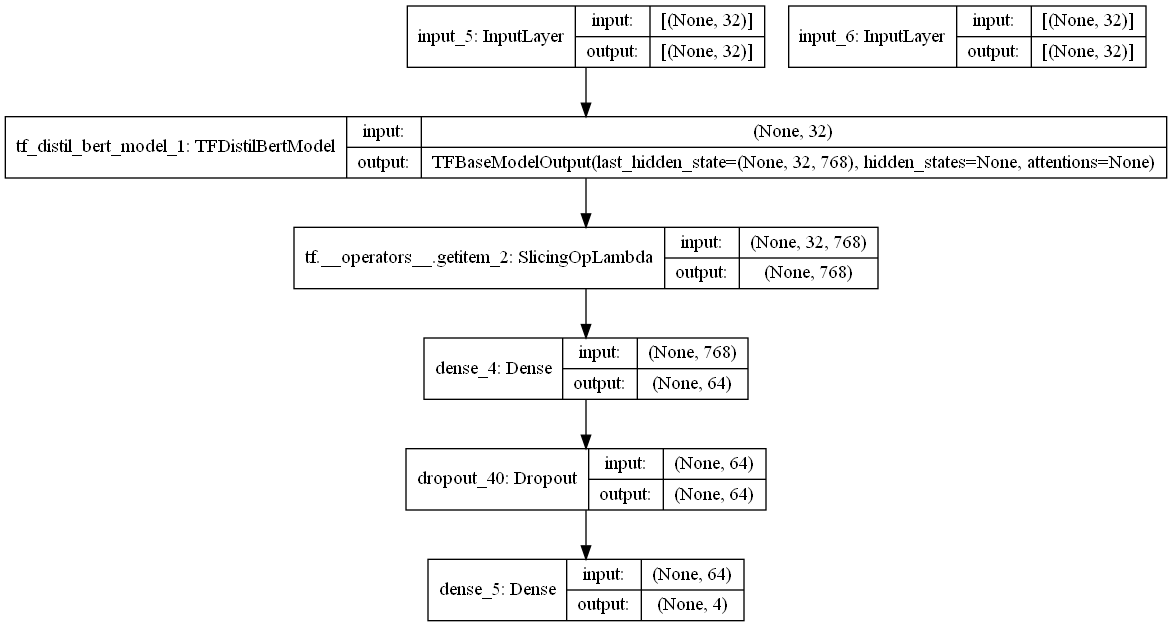

In [85]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='BERT_model_plot.png', show_shapes=True, show_layer_names=True)

In [70]:
train_inp,val_inp,train_label,val_label,train_mask,val_mask=train_test_split(input_ids,labels,attention_masks,test_size=0.2)

In [74]:
log_dir='distbert_model1'
model_save_path='./distbert_model1.h5'

callbacks = [tf.keras.callbacks.ModelCheckpoint(filepath=model_save_path,save_weights_only=True,monitor='val_loss',mode='min',save_best_only=True),keras.callbacks.TensorBoard(log_dir=log_dir)]

loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')
optimizer = tf.keras.optimizers.Adam(learning_rate=3e-5)

model.compile(loss=loss,optimizer=optimizer, metrics=[metric])

In [75]:
history=model.fit([train_inp,train_mask],train_label,batch_size=64,epochs=5,validation_data=([val_inp,val_mask],val_label),callbacks=callbacks)

Epoch 1/5
125/125 [==============================] - 497s 4s/step - loss: 1.3370 - accuracy: 0.9556 - val_loss: 1.3311 - val_accuracy: 0.9390
Epoch 2/5
125/125 [==============================] - 481s 4s/step - loss: 1.2173 - accuracy: 0.9695 - val_loss: 1.2809 - val_accuracy: 0.9315
Epoch 3/5
125/125 [==============================] - 482s 4s/step - loss: 1.1243 - accuracy: 0.9750 - val_loss: 1.2241 - val_accuracy: 0.9375
Epoch 4/5
125/125 [==============================] - 482s 4s/step - loss: 1.0230 - accuracy: 0.9861 - val_loss: 1.1845 - val_accuracy: 0.9370
Epoch 5/5
125/125 [==============================] - 481s 4s/step - loss: 0.9544 - accuracy: 0.9870 - val_loss: 1.1145 - val_accuracy: 0.9370


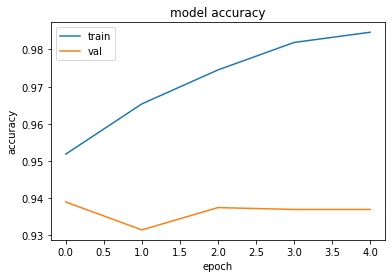

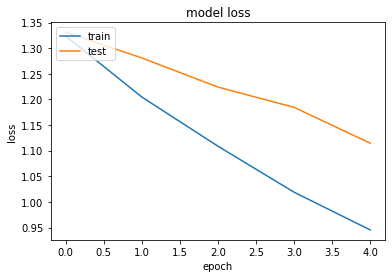

In [84]:
from matplotlib import pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()